In [2]:
import functools
import time
from tqdm.notebook import tqdm

import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, datasets, transforms

import matplotlib.pyplot as plt

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# data
# we don't need labels for unconditional image generation
train_tx = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(), # [0, 1]
    transforms.Lambda(lambda x : 2 * x - 1) # [-1, 1]
])

batch_size = 64
cifar10_ds = datasets.CIFAR10('data', train=True, download=True, transform=train_tx)
train_loader = torch.utils.data.DataLoader(cifar10_ds, batch_size=batch_size, shuffle=True, num_workers=4)

Files already downloaded and verified


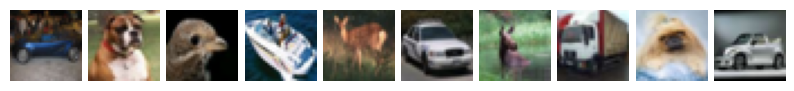

In [5]:
def show_images(x):    
    n = len(x) if isinstance(x, list) else x.shape[0] # list or batch
    nr = (n + 9) // 10
    nc = min(n, 10)
    fig = plt.figure(figsize=(nc, nr))
    for i in range(n):
        img = x[i]
        img = img.detach().cpu().numpy().transpose(1, 2, 0)
        img = (img + 1) / 2 # [-1, 1] --> [0, 1]
        img = np.clip(img, 0, 1) # might be out of [0, 1] due to added noise
        ax = plt.subplot(nr, nc, i + 1)
        plt.imshow(img)
        plt.axis('off')
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()
    
show_images([cifar10_ds[i][0] for i in np.random.randint(0, len(cifar10_ds), size=10)])

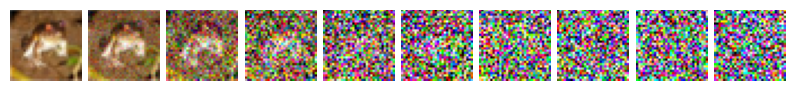

In [15]:
T = 1000
beta = torch.linspace(start=0.0001, end=0.02, steps=T) # default values from DDPM paper
alpha = 1 - beta
alphabar = torch.cumprod(alpha, axis=0)
beta = beta.to(device)
alpha = alpha.to(device)
alphabar = alphabar.to(device)

def forward_process(x0, t):
    '''
    aka diffusion process
    '''
    eps = torch.randn_like(x0).to(device)
    # xt = torch.sqrt(alphabar[t]) * x0 + (1 - alphabar[t]) * eps
    alphabar_t = alphabar[t].reshape(-1, *((1,) * (len(x0.shape) - 1))) # yes, we have batch    
    xt = torch.sqrt(alphabar_t) * x0 + (1 - alphabar_t) * eps
    return xt, eps

x0, _ = cifar10_ds[0]
xp = list()
for i, t in enumerate(range(0, T, T // 10)):
    x0 = x0.to(device)
    xt, _ = forward_process(x0, t)
    xp.append(xt.detach().cpu())    
show_images(xp)

In [16]:
tdim = 32 # time embedding dim

class BaseBlock(nn.Module):
    '''
    Base block for UNet with time embedding
    '''
    def __init__(self, inch, outch):
        super().__init__()
        self.tmlp = nn.Linear(tdim, inch)
        self.conv1 = nn.Conv2d(inch, outch, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(outch)        
        self.conv2 = nn.Conv2d(outch, outch, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(outch)
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, x, t):
        temb = self.relu(self.tmlp(t))
        temb = temb.reshape(*temb.shape, 1, 1)
        x = x + temb # time is added (what about concat?)
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        return x
    
class EncoderBlock(nn.Module):
    '''
    UNet encoder
    '''
    def __init__(self, inch, outch):
        super().__init__()
        self.base = BaseBlock(inch, outch)
        self.downsample = nn.MaxPool2d(2)
        
    def forward(self, x, t):
        x = self.base(x, t)
        y = self.downsample(x)
        return y, x # return both original and downsampled

class DecoderBlock(nn.Module):
    '''
    UNet decoder
    '''
    def __init__(self, inch, outch):
        super().__init__()
        self.upsample = nn.ConvTranspose2d(inch, outch, 2, 2)
        self.base = BaseBlock(inch, outch)
        
    def forward(self, x, f, t):
        x = self.upsample(x)
        x = torch.cat([x, f], dim=1) # concat features from encoder
        x = self.base(x, t)
        return x
    
class TimeEmbedder(nn.Module):
    '''
    Transformer Sinusoidal Position(Time) Embedding in 'Attention is All You Need' paper
    '''
    def __init__(self):
        super().__init__()
        basis = torch.exp(torch.arange(tdim // 2, device=device)
        
    def forward(self, t):
        half_tdim = tdim // 2
        emb = np.log(10000) / (half_tdim - 1)
        emb = torch.exp(torch.arange(half_tdim, device=device) * -emb)
        emb = t[:, None] * emb[None, :]
        emb = torch.cat([emb.sin(), emb.cos()], dim=-1)
        return emb
    
class SimpleUNet(nn.Module):
    def __init__(self):
        super().__init__()
        # time embedding
        self.tmlp = nn.Sequential(
            TimeEmbedder(),
            nn.Linear(tdim, tdim),
            nn.ReLU())
        # encoder blocks
        self.enc1 = EncoderBlock(3, 64)
        self.enc2 = EncoderBlock(64, 128)
        self.enc3 = EncoderBlock(128, 256)
        # bottom block
        self.bottom = BaseBlock(256, 512)
        # decoder blocks
        self.dec1 = DecoderBlock(512, 256)
        self.dec2 = DecoderBlock(256, 128)
        self.dec3 = DecoderBlock(128, 64)
        # final decode
        self.output = nn.Conv2d(64, 3, 1)
        
    def forward(self, x, t):
        t = self.tmlp(t)
        x, f1 = self.enc1(x, t)
        x, f2 = self.enc2(x, t)
        x, f3 = self.enc3(x, t)        
        x = self.bottom(x, t)
        x = self.dec1(x, f3, t)
        x = self.dec2(x, f2, t)
        x = self.dec3(x, f1, t)
        x = self.output(x)
        return x
        
net = SimpleUNet().to(device)
x = torch.randn(32, 3, 64, 64).to(device)
t = torch.randint(0, T, (32,), dtype=torch.float32).to(device)
print(net(x, t).shape)

torch.Size([32, 3, 64, 64])


  0%|          | 0/100 [00:00<?, ?it/s]

1/100: train_loss=0.000313
2/100: train_loss=0.000280
3/100: train_loss=0.000240
4/100: train_loss=0.000173
5/100: train_loss=0.000179
6/100: train_loss=0.000192
7/100: train_loss=0.000192
8/100: train_loss=0.000131
9/100: train_loss=0.000127
10/100: train_loss=0.000219
11/100: train_loss=0.000185
12/100: train_loss=0.000259
13/100: train_loss=0.000137
14/100: train_loss=0.000302
15/100: train_loss=0.000188
16/100: train_loss=0.000162
17/100: train_loss=0.000227
18/100: train_loss=0.000117
19/100: train_loss=0.000151
20/100: train_loss=0.000203
21/100: train_loss=0.000194
22/100: train_loss=0.000202
23/100: train_loss=0.000187
24/100: train_loss=0.000189
25/100: train_loss=0.000161
26/100: train_loss=0.000238
27/100: train_loss=0.000228
28/100: train_loss=0.000157
29/100: train_loss=0.000167
30/100: train_loss=0.000105
31/100: train_loss=0.000164
32/100: train_loss=0.000296
33/100: train_loss=0.000156
34/100: train_loss=0.000226
35/100: train_loss=0.000203
36/100: train_loss=0.000220
3

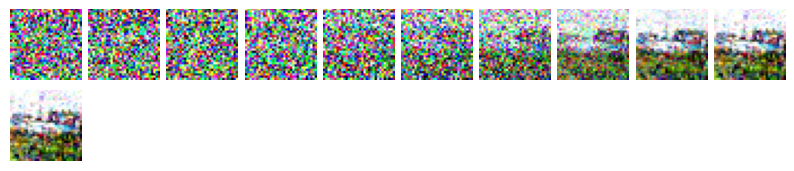

In [80]:
def loss_func(model, x0, t):
    '''
    simple loss in DDPM paper
    '''
    xt, eps = forward_process(x0, t) # t is used as index    
    eps_pred = model(xt, torch.tensor(t, dtype=torch.float32).to(device)) # t is used for time modulation
    loss = nn.functional.l1_loss(eps, eps_pred)
    return loss
    
def train(model, dataloader, optimizer):
    model.train()    
    loss_ = 0
    for idx, (images, labels) in enumerate(dataloader):
        images = images.to(device)
        optimizer.zero_grad()
        t = np.random.randint(0, T, images.shape[0])
        loss = loss_func(model, images, t)        
        loss.backward()
        optimizer.step()
        loss_ = loss.item()
    loss_ /= len(dataloader)
    return loss_

def reverse_process(model, show_progress=False):
    '''
    aka sampling
    '''
    model.eval()    
    x = torch.randn_like(cifar10_ds[0][0]).unsqueeze(0).to(device)    
    xp = list()
    for t in range(T - 1, -1, -1):
        z = torch.randn_like(x) if t > 1 else torch.zeros_like(x)
        z = z.to(device)
        eps_pred = model(x, torch.tensor(t, dtype=torch.float32).unsqueeze(0).to(device))
        x_pred = 1 / torch.sqrt(alpha[t]) * (x - beta[t] / torch.sqrt(1 - alphabar[t]) * eps_pred) + torch.sqrt(beta[t]) * z
        x = x_pred # x_t --> x_(t-1)
        if t % (T // 10) == 0:
            xp.append(x[0])
    xp.append(x[0])
    if show_progress:
        show_images(xp)
    return x

# main
epochs = 100
model = SimpleUNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=2e-4)
train_log = list()
for epoch in tqdm(range(1, epochs + 1)):
    train_loss = train(model, train_loader, optimizer)
    print(f"{epoch}/{epochs}: train_loss={train_loss:.6f}")
    train_log.append(train_loss)
x = reverse_process(model, show_progress=True)

In [14]:
a = torch.zeros(32, 3, 8, 8)
#temb = temb[(...,) + (None, ) * 2]
b = a[(...,) + (None, ) * 2]
c = a.reshape(*a.shape, 1, 1)
print(a.shape, b.shape, c.shape)

torch.Size([32, 3, 8, 8]) torch.Size([32, 3, 8, 8, 1, 1]) torch.Size([32, 3, 8, 8, 1, 1])
